In [162]:
import sys
from pathlib import Path
from argparse import ArgumentParser, Namespace
from collections import Counter
import pickle

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import geopandas as gdp
from tqdm import tqdm

sys.path.append("..")

from src.models import STR2MODEL
from src.engineer import GeoWikiEngineer
from src.exporters.sentinel.cloudfree import BANDS

## Initialize model

Adding args=[] makes it work for Jupyter notebook https://stackoverflow.com/questions/30656777/how-to-call-module-written-with-argparse-in-ipython-notebook

In [3]:
# Get model default args
parser = ArgumentParser()
model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[]) 
model_args_dict = vars(model_args)

# Change default hyperparameters
model_args_dict['add_togo'] = False
model_args_dict['multi_headed'] = False
model_args_dict['num_classification_layers'] = 1

# Initialize model
model_args = Namespace(**model_args_dict)
model = STR2MODEL["land_cover"](model_args)
model.hparams

Number of geowiki instances in training set: 27947


Namespace(add_geowiki=True, add_togo=False, alpha=10, batch_size=64, data_folder='/home/gajo/code/togo-crop-mask/notebooks/../data', hidden_vector_size=64, learning_rate=0.001, lstm_dropout=0.2, model_base='lstm', multi_headed=False, num_classification_layers=1, num_lstm_layers=1, probability_threshold=0.5, remove_b1_b10=True)

## 1. Labels distribution

### 1a. Geowiki train and validation

Training set

In [4]:
train_loader = model.train_dataloader()
counter = Counter()
for sample in train_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in training set: 27947


In [5]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 22.1%
Non-cropland: 77.9%


Validation set


In [6]:
val_loader = model.val_dataloader()
counter = Counter()
for sample in val_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Number of geowiki instances in validation set: 7301


In [7]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 21.2%
Non-cropland: 78.8%


### 1b. Nigeria farmlands test set

In [8]:
test_loader = model.test_dataloader()
counter = Counter()
for sample in test_loader:
    x, y, weight = sample
    counter.update(y.numpy())

Evaluating using the Nigeria evaluation dataset!
Number of instances in nigeria_farmlands_v2 test set: 739


In [9]:
cropland_ratio = counter[1.0] / (counter[0.0] + counter[1.0])
print(f'Cropland: {100*cropland_ratio:.1f}%')
print(f'Non-cropland: {100*(1-cropland_ratio):.1f}%')

Cropland: 53.2%
Non-cropland: 46.8%


<font color='red'> **The target dataset has a very different balance of labels, many more cropland labels compared to training and validation set!** </font>

## 2. Data distribution

Mean and std of each bands in a nice plot. Use normalizing dicts. Normalizing dict has 14 bands but my model has only 12. Anyways plot distribution of all bands.

### 2a. Geowiki train and val

In [163]:
# Get bands names
full_bands = BANDS + ['NDVI'] if (model.input_size == 12) or (model.input_size == 14) else BANDS
bands_to_remove = ["B1", "B10"] if model.hparams.remove_b1_b10 else []

In [164]:
# Keep only means and stdevs of bands we have
means = model.normalizing_dict['mean']
stdevs = model.normalizing_dict['std']

indices_to_remove = []
for band in bands_to_remove:
    indices_to_remove.append(full_bands.index(band))

indices_to_keep = [i for i in range(len(full_bands)) if i not in indices_to_remove]

bands = [full_bands[index] for index in indices_to_keep]
means_geowiki_full = means[indices_to_keep]
stdevs_geowiki_full = stdevs[indices_to_keep]

/home/gajo/miniconda3/envs/togo-paper/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


Text(0.5, 0.98, 'Data distribution per band')

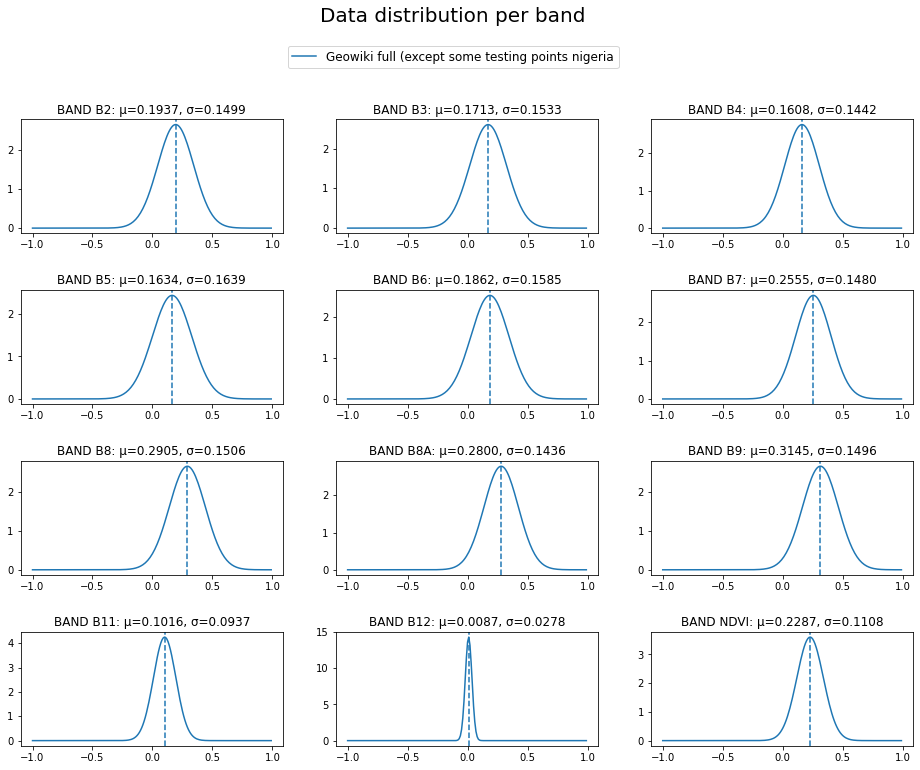

In [220]:
# Generate plots
num_plots = len(bands)
n_cols = 4
n_rows = num_plots // n_cols if num_plots % n_cols == 0 else num_plots // n_cols + 1

fig, subplots = plt.subplots(n_cols, n_rows, figsize=(16, 12))

x_axis = np.arange(-1, 1, 0.01)
for i in range(num_plots):
    mean = means[i]
    std = stdevs[i]
    ax = plt.subplot(n_cols, n_rows, i + 1)
    ax.plot(x_axis, norm.pdf(x_axis, mean, std), label='Geowiki full (except some testing points nigeria')
    ax.axvline(mean, ls='--')
    ax.set_title(f'BAND {bands[i]}: \u03BC={mean:.4f}, \u03C3={std:.4f}')

plt.legend(bbox_to_anchor=(-0.1, 6.2), fontsize=12)
plt.subplots_adjust(top=0.85, hspace=0.5)
fig.tight_layout()
fig.suptitle('Data distribution per band', fontsize=20)
    

### 2b. Nigeria farmlands test set

Need to recalculate normalizing dict for getting it